In [ ]:
import sys
!{sys.executable} -m pip install imutils

In [1]:
import cv2,os
import matplotlib.pyplot as plt
import numpy as np


connect digits in image to get appropriate bounding box

*** Another way to bound digits together is run the contours on the noise reduced images then split the image into chunks around bands of all black of a certain width...  This might have the advantage of not making the colon stick to digits in blurrier images and allowing the colon and decimal point to be read. ***

Resized Dimensions :  (500, 1037)
Thresholded Image:


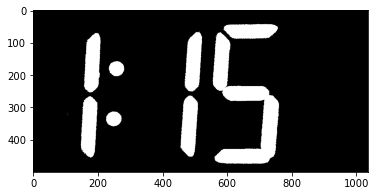

Median Blurred Image:


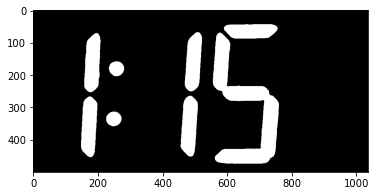

Dilated Image:


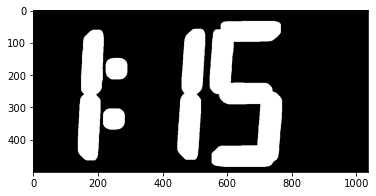

In [3]:
img = cv2.cvtColor(cv2.imread('1151.png'), cv2.COLOR_BGR2GRAY)
desired_height = 500 #500 pixels
scale_percent = desired_height / img.shape[0] * 100 # percent of original size
# print(scale_percent)
# scale_percent = 60 
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image -- scale all images to 500 px height 
# this is to ensure the same morphological operations happen to all the images
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',img.shape)

#threshold the image
# this makes sure that the noise below 127 color is converted to black and the rest is white
ret, thresh = cv2.threshold(img, 127, 255, 0)

# show thresholded image
print("Thresholded Image:")
plt.imshow(thresh, cmap='Greys_r')
plt.show()

# perform median blur to eliminate remaining small noise in image
median = cv2.medianBlur(thresh, 9)

#show median blurred image
print("Median Blurred Image:")
plt.imshow(median, cmap='Greys_r')
plt.show()

# dilate image to connect 7 segment digits that are otherwise separate
# this allows the contours of the digits to identify digits as one connected digit instead of just segments
dilated = cv2.dilate(median, np.ones((21,21), np.uint8), iterations=1)

#show dilated image
print("Dilated Image:")
plt.imshow(dilated, cmap='Greys_r')
plt.show()

Contoured Median Blur Image:


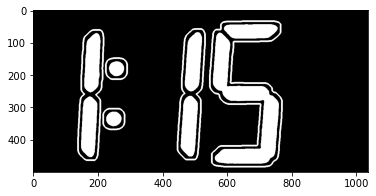

In [4]:
# find contours of dilated image
conts, hierarchy = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# draw the contours on the original median blurred image 
median_copy = median.copy()
cv2.drawContours(median_copy, conts, -1, (255,255,0), 3)


#show contours on image:
print("Contoured Median Blur Image:")
plt.imshow(median_copy, cmap='Greys_r')
plt.show()

(217, 304, 67, 65)
(225, 148, 67, 66)
(139, 61, 80, 403)


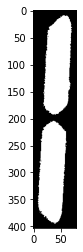

(447, 58, 86, 404)


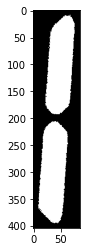

(547, 34, 224, 450)


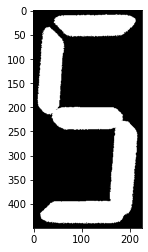

Bounding Box Contoured Median Blur Image:


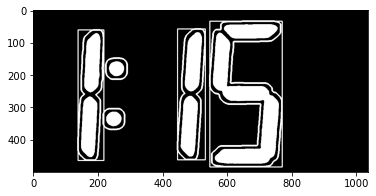

In [7]:
digits = {}
for c in conts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	#show dims of bounding box for debugging purposes
	print((x, y, w, h))
# 	# if the contour is sufficiently large, it must be a digit
	if h >= 300 and h <= 500:
		# drop digit to bouding box:
		crop_img = thresh[y:y+h, x:x+w]
		# add digit to dictionary that sorts the digits by x-axis coordinate to preserve digit order:
		digits[x] = crop_img
		# show image
		plt.imshow(crop_img, cmap='Greys_r')
		plt.show()
		# draw bounding rectangle on median copy to for debugging purposes
		cv2.rectangle(median_copy, (x, y), (x+w, y+h), (255, 255, 0), 2)

print("Bounding Box Contoured Median Blur Image:")
plt.imshow(median_copy, cmap='Greys_r')
plt.show()

In [8]:
import cv2
import os
import numpy as np

#function to get place digit in larger black background for classification
def place_in_same_size_image(img):

    def findCenter(img):
        h,w = img.shape
        return h//2,w//2

    img1 = np.zeros((600,400), thresh.dtype)
    img2 = img

    pt1 = findCenter(img1)
    pt2 = findCenter(img2)

    ## (2) Calc offset
    dx = (pt1[0] - pt2[0])
    dy = (pt1[1] - pt2[1])

    h, w = img2.shape[:2]

    dst = img1.copy()
    dst[dy:dy + h, dx:dx + w] = img2
    return dst



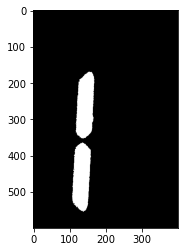

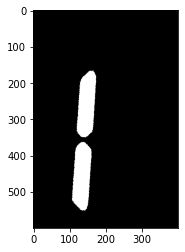

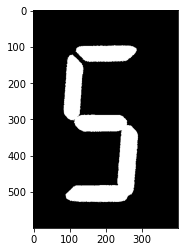

In [9]:
# display images in order:
for key in sorted(digits.keys()):
    digit = digits[key]
#     print(digit.shape)
    plt.imshow(place_in_same_size_image(digit), cmap='Greys_r')
    plt.show()

In [10]:
import keras

reconstructed_model = keras.models.load_model("digit_model")

1


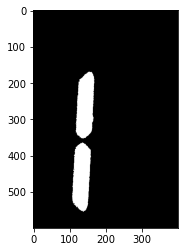

1


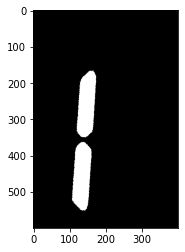

5


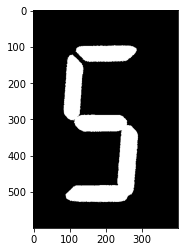

In [11]:
for key in sorted(digits.keys()):
    digit = digits[key]
    img = place_in_same_size_image(digit)
    x = np.array(img)
    print(np.argmax(reconstructed_model.predict(x.reshape((1,600,400,1)))))
    
    plt.imshow(x, cmap='Greys_r')
    plt.show()

## Alternate Bounding Box Method:

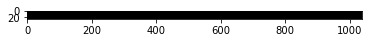

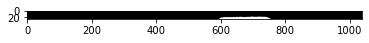

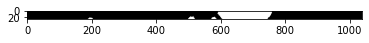

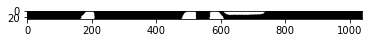

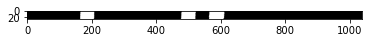

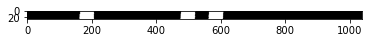

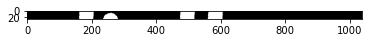

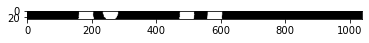

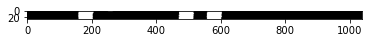

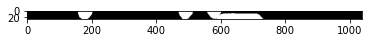

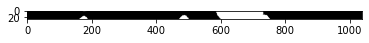

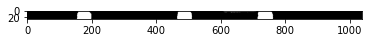

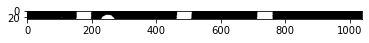

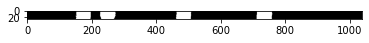

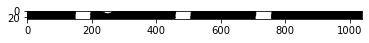

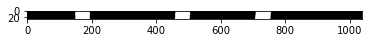

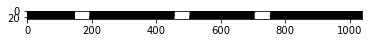

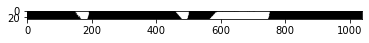

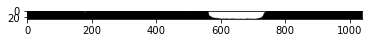

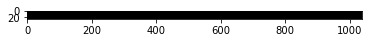

25 475


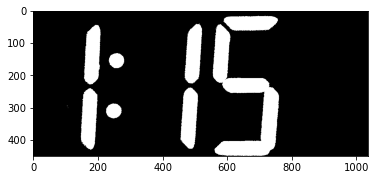

In [13]:
t = np.array(thresh.copy())

# horizontal slicing:
resulting_horizontal_slices = []

number_of_hor_slices = 20
slice_height = t.shape[0]//number_of_hor_slices


for i in range(number_of_hor_slices):
    slice_i = t[i*slice_height:(i+1)*slice_height,:]
    average_pixel_intensity = np.mean(slice_i)
    if average_pixel_intensity > 5:
        resulting_horizontal_slices.append(i)
    plt.imshow(slice_i, cmap='Greys_r')
    plt.show()


# identifying digit pixel range from horizontal slices

start_pixel_height = resulting_horizontal_slices[0]*slice_height
end_pixel_height = (resulting_horizontal_slices[-1]+1)*slice_height
print(start_pixel_height,end_pixel_height)

#show cropped image
plt.imshow(t[start_pixel_height:end_pixel_height,:], cmap='Greys_r')
plt.show()

t = t[start_pixel_height:end_pixel_height,:]

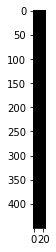

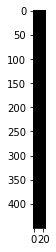

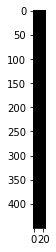

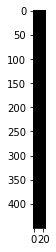

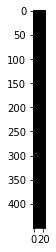

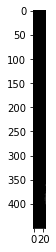

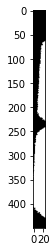

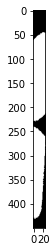

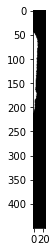

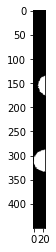

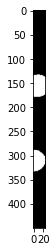

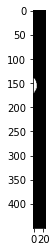

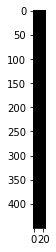

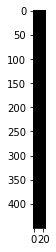

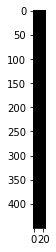

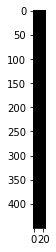

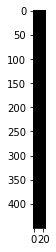

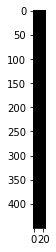

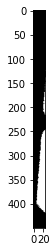

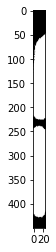

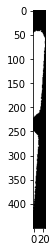

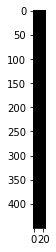

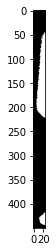

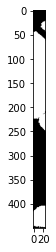

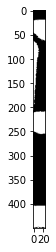

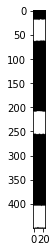

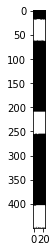

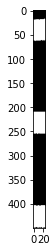

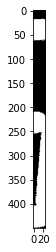

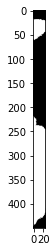

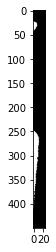

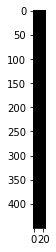

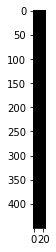

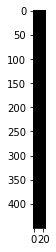

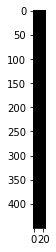

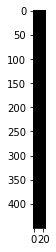

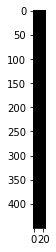

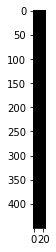

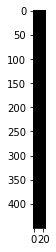

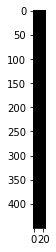

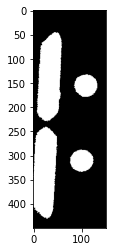

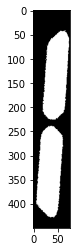

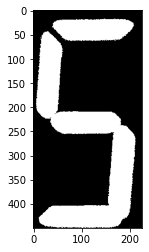

In [16]:
# vertical slicing:
number_of_vert_slices = 40
resulting_digit_slices = []
slice_width = t.shape[1]//number_of_vert_slices
is_black = True

for i in range(number_of_vert_slices):
    slice_i = t[:,i*slice_width:(i+1)*slice_width]
    average_pixel_intensity = np.mean(slice_i)
    if average_pixel_intensity > 3:
        
        if is_black==True:
            resulting_digit_slices.append([i])
        else:
            resulting_digit_slices[-1].append(i)
        is_black = False
    else:
        is_black = True
    plt.imshow(slice_i, cmap='Greys_r')
    plt.show()

# identifying digits from groups of vertical slices:

digits = []

for digit_slices in resulting_digit_slices:
    start_pixel_width = digit_slices[0]*slice_width
    end_pixel_width = (digit_slices[-1]+1)*slice_width
    digits.append(t[:,start_pixel_width:end_pixel_width])

# show cropped digits:
for digit in digits:
    plt.imshow(digit, cmap='Greys_r')
    plt.show()